In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from mbipy.numpy.phase_retrieval import cst, wst, csvt, wsvt

with h5py.File("./data/BeLens.h5", "r") as f:
    sample = f["50"]["sample"][:]
    reference = f["50"]["reference"][:]

    sample = sample.astype(np.float64) / np.iinfo(sample.dtype).max
    reference = reference.astype(np.float64) / np.iinfo(reference.dtype).max

sample.shape, reference.shape

((10, 900, 900), (10, 900, 900))

In [2]:
def plot_results(titles, results, figsize=None):
    assert len(titles) == len(results)
    size = len(results)
    fig = plt.figure(layout="constrained", figsize=figsize or (8, 4 * size))
    subfigs = fig.subfigures(size, 1, wspace=0.07)
    for i, j in enumerate(titles):
        subfigs[i].suptitle(j)

    for i, j in enumerate(results):
        axes = subfigs[i].subplots(1, 2, sharex=True, sharey=True)
        im0 = axes[0].imshow(j[0])
        im1 = axes[1].imshow(j[1])
        plt.colorbar(im0, ax=axes[0], fraction=0.05, pad=0.04)
        plt.colorbar(im1, ax=axes[1], fraction=0.05, pad=0.04)

In [3]:
N = 0
ss = (15, 15)
ts = (7, 7)

cutoff = 15

In [4]:
%%time
result_cst = cst(reference[N], sample[N], ss, ts, dct_kwargs={"workers": 8}, cutoff=cutoff)

CPU times: user 3.04 s, sys: 541 ms, total: 3.58 s
Wall time: 3.37 s


In [5]:
%%time
result_wst = wst(reference[N], sample[N], ss, ts, cutoff=cutoff, level_cutoff=3)

CPU times: user 3.07 s, sys: 540 ms, total: 3.61 s
Wall time: 3.69 s


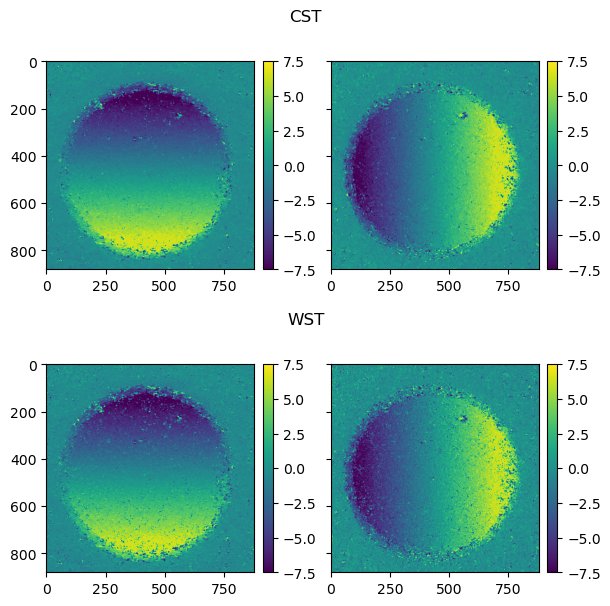

In [6]:
plot_results(["CST", "WST"], [result_cst, result_wst], (6, 6))

In [13]:
cutoff = 5
reference.shape, sample.shape

((10, 900, 900), (10, 900, 900))

In [19]:
%%time
result_csvt = csvt(reference, sample, 7, 7, dct_kwargs={"workers": 1}, cutoff=cutoff)

CPU times: user 2.72 s, sys: 430 ms, total: 3.15 s
Wall time: 3.22 s


In [20]:
%%time
result_wsvt = wsvt(reference, sample, 7, 7, cutoff=cutoff)

CPU times: user 2.77 s, sys: 439 ms, total: 3.21 s
Wall time: 3.29 s


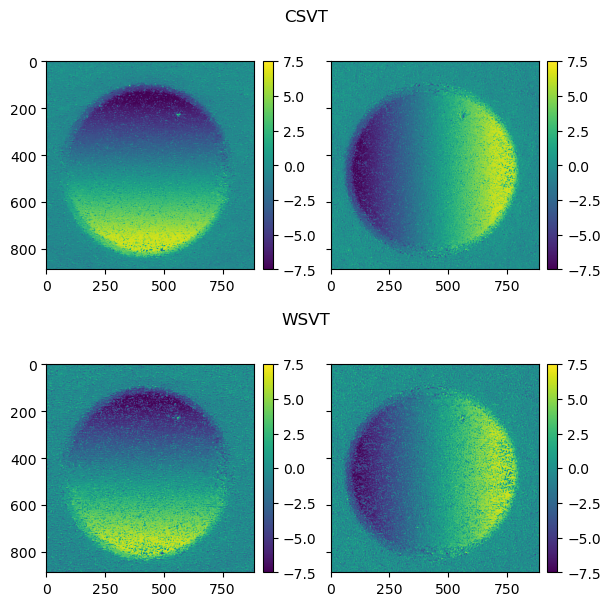

In [21]:
plot_results(["CSVT", "WSVT"], [result_csvt, result_wsvt], (6, 6))

In [34]:
import pywt
from scipy import fft
import numpy as np

rng = np.random.default_rng()

shape = (1000, 1000)
window = (7, 7)

resulting_shape = tuple(np.subtract(shape, window) + 1) + window
print(resulting_shape)

img = rng.random((1000, 1000))

img = np.lib.stride_tricks.sliding_window_view(img, (7, 7)).reshape(resulting_shape[:-2]+(-1,))

print(img.shape)

%timeit fft.dct(img, axis=-1, workers=1)
%timeit pywt.wavedec(img, "db2", axis=-1, mode="zero")

(994, 994, 7, 7)
(994, 994, 49)
201 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
337 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
